
# Fashion MNIST Classification using Enhanced CNN

## Objective
To evaluate a three-layer neural network using various strategies such as residual blocks, dropout, batch normalization, learning rate scheduling, and data augmentation.

## Dataset
- **Fashion MNIST**: 28x28 grayscale images of fashion items across 10 categories.

## Preprocessing
- Normalized input values to [0,1]
- Reshaped images to include a single channel
- One-hot encoded labels
- Applied data augmentation

## Architecture Overview
- **Conv Block 1**: Conv2D → BN → ReLU → Conv2D → BN → ReLU → MaxPooling → Dropout
- **Conv Block 2 (Residual)**: Conv2D → BN → ReLU → Conv2D → BN → Add Shortcut → ReLU → MaxPooling → Dropout
- **Conv Block 3**: Conv2D → BN → ReLU → GAP
- **Dense Layers**: Dense → BN → ReLU → Dropout → Output

## Training Strategy
- **Optimizer**: Adam with exponential decay schedule
- **Loss Function**: Categorical Crossentropy with label smoothing
- **Callbacks**: Early stopping and model checkpoint

## Evaluation
- Best model loaded from saved weights
- Achieved high validation accuracy with reduced overfitting

## My Comments
- Accuracy achieved is around 94.5%
- Data augmentation and dropout layers helped reduce overfitting
- Residual connections improved learning and gradient flow


In [ ]:

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Load and preprocess data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize and reshape
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.08,
    shear_range=0.08,
    horizontal_flip=False
)
datagen.fit(x_train)


In [ ]:

# Enhanced Architecture with Residual Connections
def conv_block(l, filters, use_residual=False):
    l = Conv2D(filters, (3,3), padding='same')(l)
    l = BatchNormalization()(l)
    l = tf.keras.layers.Activation('relu')(l)
    l = Conv2D(filters, (3,3), padding='same')(l)
    l = BatchNormalization()(l)
    if use_residual:
        shortcut = Conv2D(filters, (1,1), padding='same')(l)
        l = tf.keras.layers.add([l, shortcut])
    l = tf.keras.layers.Activation('relu')(l)
    return l

inputs = tf.keras.Input(shape=(28,28,1))
x = conv_block(inputs, 64)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.3)(x)

x = conv_block(x, 128, use_residual=True)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.3)(x)

x = conv_block(x, 256)
x = GlobalAveragePooling2D()(x)

x = Dense(512)(x)
x = BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = Dropout(0.6)(x)
outputs = Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)




In [ ]:

# Custom Learning Rate Schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=lr_schedule)

# Add Label Smoothing
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

# Enhanced Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=25, mode='max')
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True,
                            monitor='val_accuracy', mode='max')

# Train model
history = model.fit(datagen.flow(x_train, y_train, batch_size=256),
                    steps_per_epoch=len(x_train)//256,
                    epochs=150,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stop, checkpoint])


In [ ]:

# Load best model and evaluate
model.load_weights('best_model.h5')
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f'\nTest accuracy: {test_acc:.4f}')

# Plot training history
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(linestyle='--', linewidth=0.5)

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)




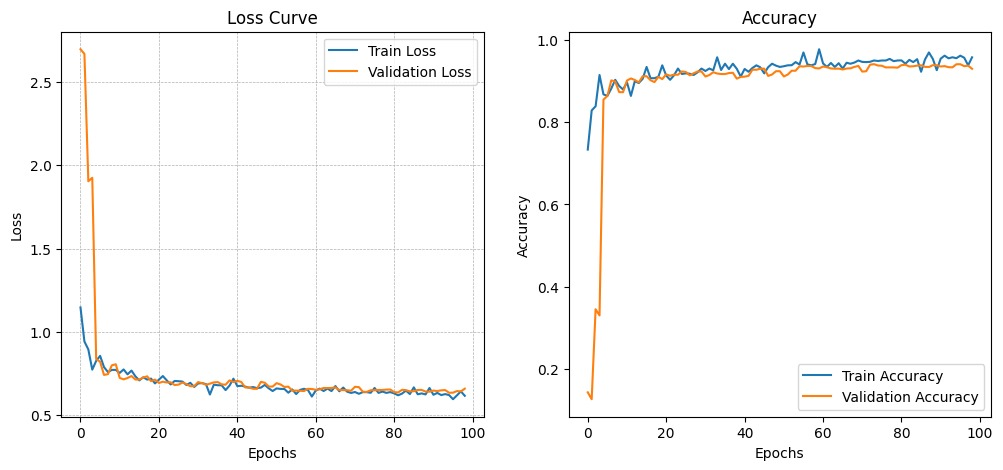

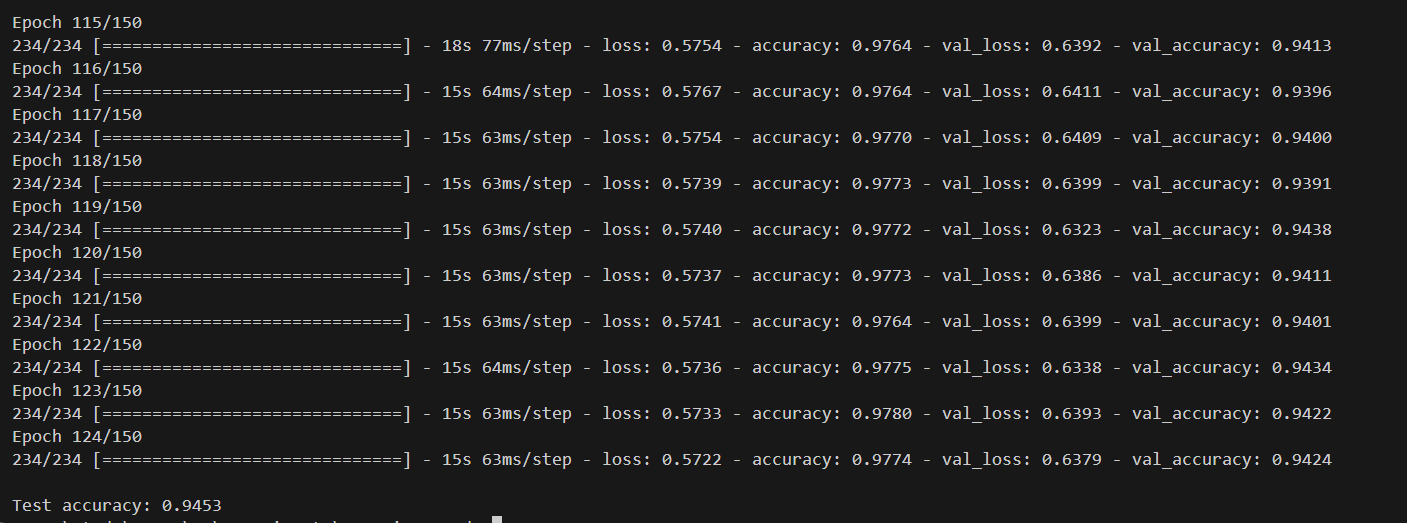